In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as mse

from itertools import product

In [2]:
df = pd.read_csv('ts_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   shop_id       1000 non-null   int64
 1   time          1000 non-null   int64
 2   transactions  1000 non-null   int64
dtypes: int64(3)
memory usage: 23.6 KB


,shop_id,time,transactions
0,145,311,132
1,145,312,107
2,145,313,52
3,145,314,73
4,145,315,53


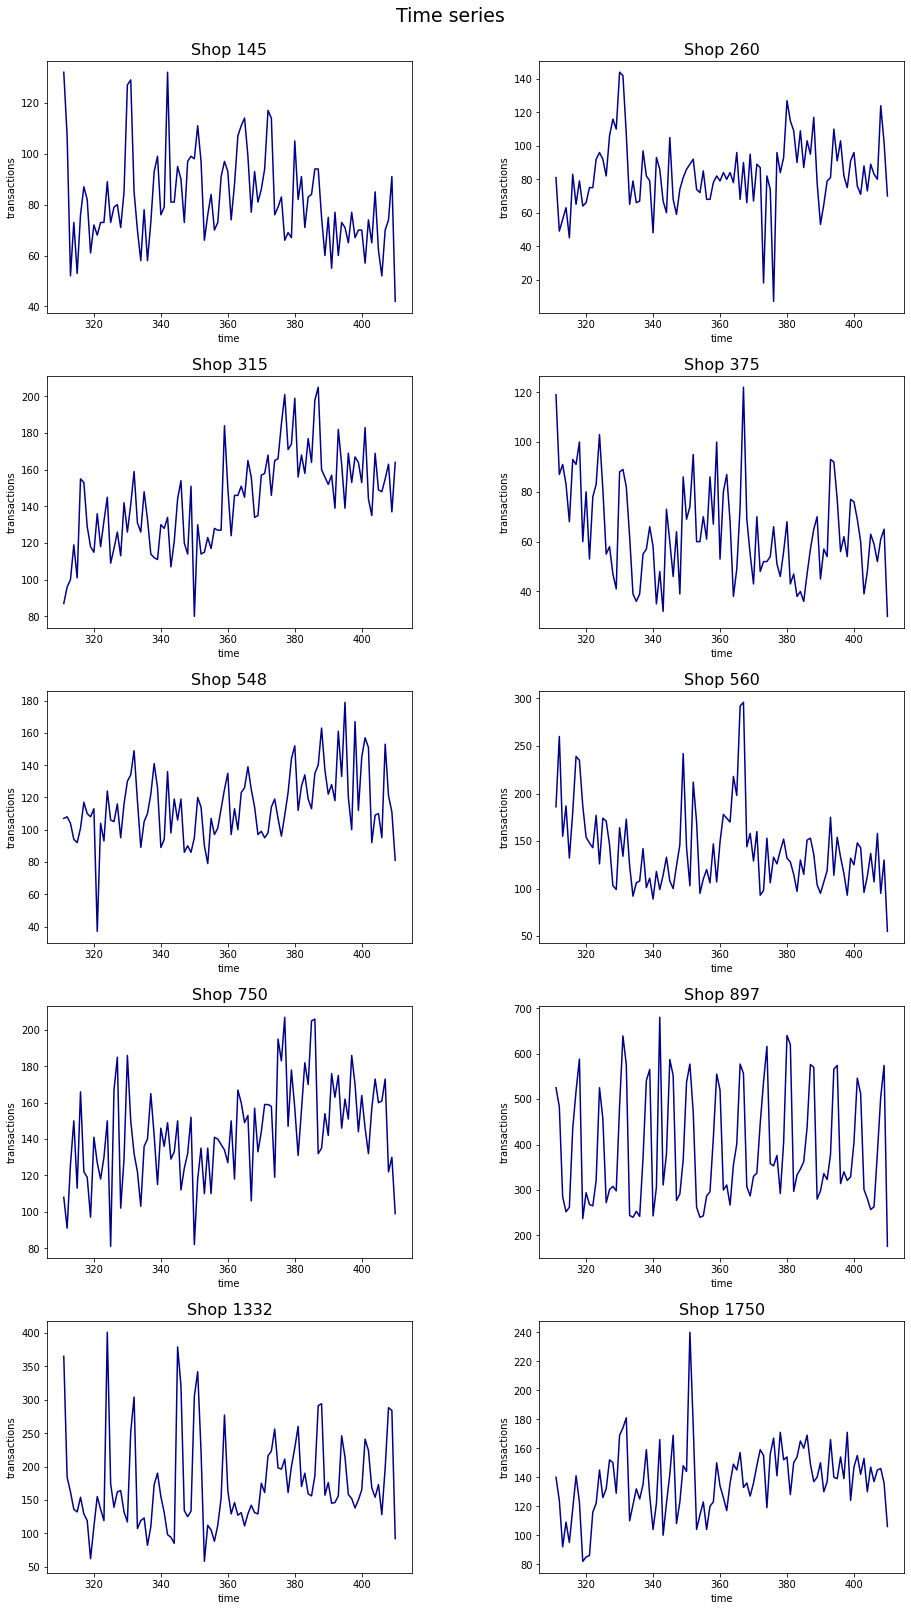

In [3]:
subplot_args = { 'nrows': 5, 'ncols': 2, 'figsize': (14, 25)}
fig, ax = plt.subplots(**subplot_args)
fig.suptitle("Time series", y=0.95, fontsize=19)
fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, 
                    hspace=0.25, wspace=0.35)

for i, ts in enumerate(df.groupby('shop_id')):
    ax = ax.flatten()
    ax[i].plot(ts[1]['time'], ts[1]['transactions'], color="darkblue")
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("transactions")
    ax[i].set_title("Shop " + str(ts[0]), fontsize=16)

In [4]:
# Matrixmultiplikation bei AR und MA, Reihenfolge, shift

# nur calc, nicht optimized
def ARMA(ts, p, q, *x):
    phi = x[0][1:p+1]
    c = x[0][0]
    theta = x[0][p+1:]
    
    time_series = list(ts[1]['transactions'])
    
    forecast = list()
    for ts, _ in enumerate(time_series):
        AR = sum(phi[i] * time_series[ts-(i+1)] for i in range(min(ts, p))) + c
        MA = sum(theta[i] * (time_series[ts-(i+1)] - forecast[ts-(i+1)]) 
                 for i in range(min(ts, q)))
        forecast.append(AR + MA)
    return forecast

# mindest-zeitreihenlänge die ersten Werte zur Berechnung weglassen (je nach Länge der Zeitreihe)
def MSE(ts, p, q, *x):
    return mse(list(ts[1]['transactions']), ARMA(ts, p, q, *x))

def optimize(ts, p, q):
    optimum = minimize(lambda x: MSE(ts,p,q, x),
                       np.full(shape=1+p+q, fill_value=1.5), 
                       method='nelder-mead')
    forecast = ARMA(ts, p, q, optimum.x)
    return optimum, forecast

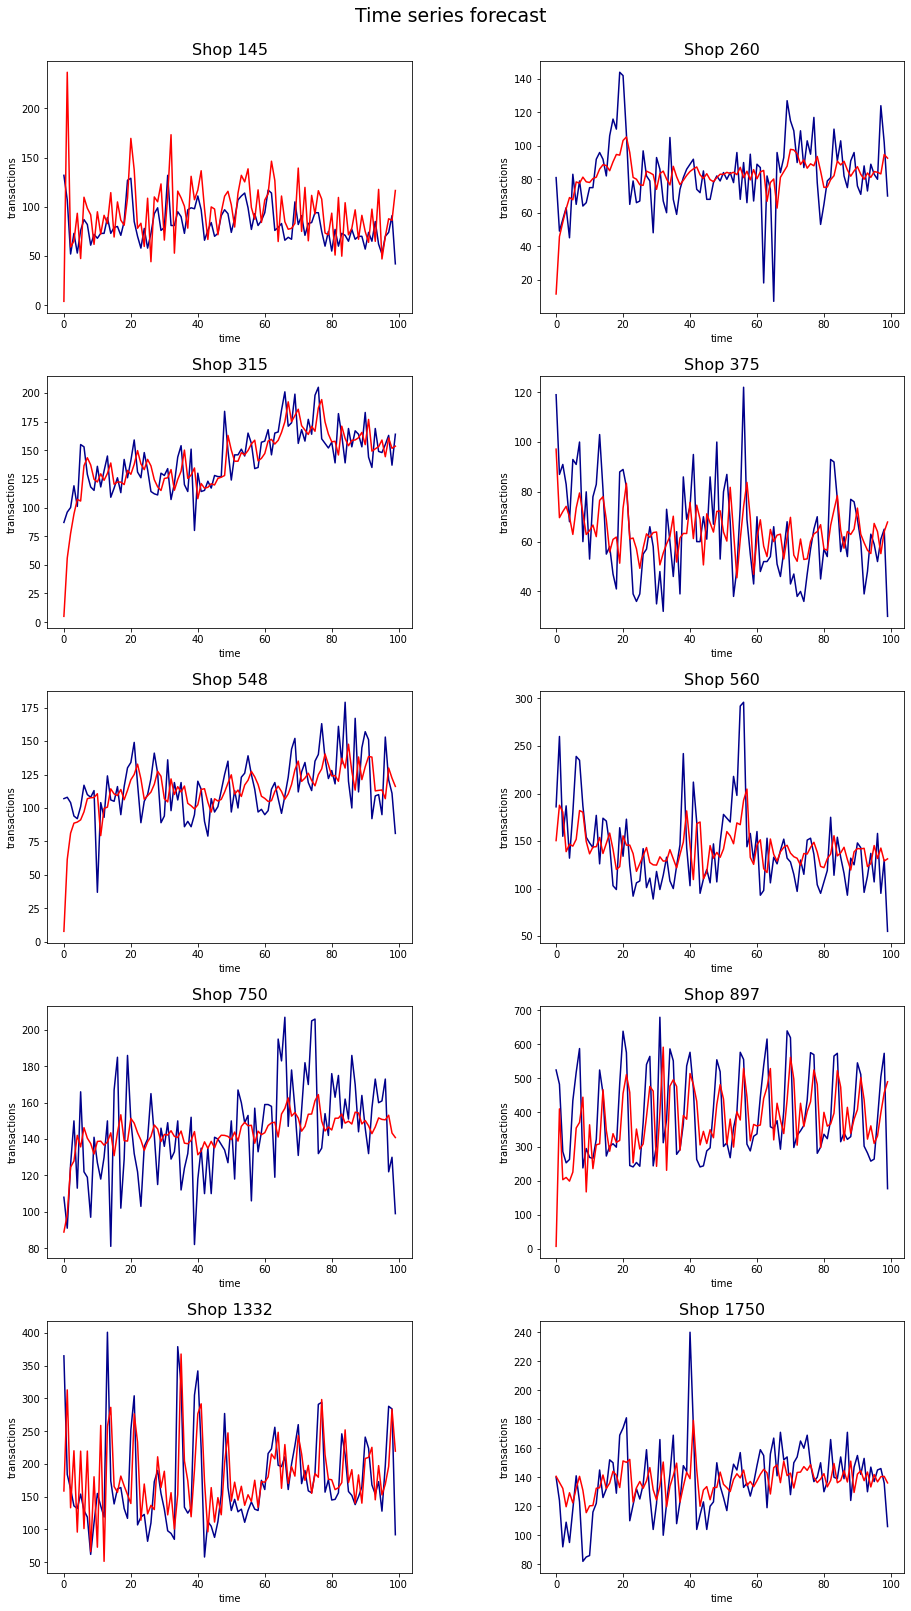

In [5]:
subplot_args = { 'nrows': 5, 'ncols': 2, 'figsize': (14, 25)}
fig, ax = plt.subplots(**subplot_args)
fig.suptitle("Time series forecast", y=0.95, fontsize=19)
fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, 
                    hspace=0.25, wspace=0.35)

for i, ts in enumerate(df.groupby('shop_id')):
    time_series = ts[1]['transactions']
    # p=2, q=2
    _, forecast = optimize(ts, 2, 2)
    ax = ax.flatten()
    ax[i].plot(range(len(time_series)), time_series, color="darkblue")
    ax[i].plot(range(len(time_series)), forecast, color="red")
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("transactions")
    ax[i].set_title("Shop " + str(ts[0]), fontsize=16)

In [9]:
for i, ts in enumerate(df.groupby('shop_id')):
    comb = dict()
    comb[ts[0]] = [0,0,99999,0]
    # Grid search
    for p, q in product([0,1,2,3], [0,1,2,3]):
        optimum, forecast = optimize(ts, p, q)
        mean_squared_error = mse(list(ts[1]['transactions']), forecast)
        if mean_squared_error < comb[ts[0]][2]:
            comb[ts[0]] = [p, q, mean_squared_error, optimum.x[0]]
    print(f'Shop {ts[0]}: '
          f'MSE: {round(comb[ts[0]][2], 3)}    '
          f'p={comb[ts[0]][0]} '
          f'q={comb[ts[0]][1]}')
    

# Shop 145: MSE: 260.699    p=1 q=2
# Shop 260: MSE: 344.175    p=0 q=3
# Shop 315: MSE: 331.742    p=3 q=0
# Shop 375: MSE: 271.036    p=2 q=2
# Shop 548: MSE: 405.978    p=1 q=3
# Shop 560: MSE: 1410.566    p=1 q=3
# Shop 750: MSE: 573.184    p=3 q=1
# Shop 897: MSE: 10305.74    p=0 q=3
# Shop 1332: MSE: 3803.477    p=1 q=2
# Shop 1750: MSE: 469.531    p=3 q=1
        
        
# CPU times: user 1min 21s, sys: 498 ms, total: 1min 21s
# Wall time: 1min 27s

Shop 145: MSE: 260.699    p=1 q=2
Shop 260: MSE: 344.175    p=0 q=3
Shop 315: MSE: 331.742    p=3 q=0
Shop 375: MSE: 271.036    p=2 q=2
Shop 548: MSE: 405.978    p=1 q=3
Shop 560: MSE: 1410.566    p=1 q=3
Shop 750: MSE: 573.184    p=3 q=1
Shop 897: MSE: 10305.74    p=0 q=3
Shop 1332: MSE: 3803.477    p=1 q=2
Shop 1750: MSE: 469.531    p=3 q=1
CPU times: user 1min 21s, sys: 498 ms, total: 1min 21s
Wall time: 1min 27s
